In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from lightgbm import LGBMRanker, LGBMRegressor
from multiprocessing import cpu_count

In [71]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2, rank_col='Rank') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df[rank_col].min() == 0
        assert df[rank_col].max() == len(df[rank_col]) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by=rank_col)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by=rank_col, ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf


In [3]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

In [4]:
def sign_checker(x, y):
    if x >= 0 and y >= 0:
        return 1
    elif x < 0 and y < 0:
        return 1
    else:
        return 0

In [5]:
train = pd.read_parquet('../Output/financials_train_agg_df.parquet')
val = pd.read_parquet('../Output/financials_val_agg_df.parquet')
df = pd.concat([train, val]).reset_index(drop=True)
rank_num = 100
df["qcut"] = pd.qcut(df['Target'], rank_num, duplicates='drop').cat.codes

In [6]:
df["Section/Products"] = df["Section/Products"].astype('category').cat.codes
df["NewMarketSegment"] = df["NewMarketSegment"].astype('category').cat.codes
df["33SectorCode"] = df["33SectorCode"].astype('category').cat.codes
df["17SectorCode"] = df["17SectorCode"].astype('category').cat.codes
df["NewIndexSeriesSizeCode"] = df["NewIndexSeriesSizeCode"].astype('category').cat.codes
df["week"] = df["week"].astype('category').cat.codes
df["TypeOfDocument"] = df["TypeOfDocument"].astype('category').cat.codes

In [7]:
def rolling_mean(df, target_col, period=5):
    rolling_df = pd.DataFrame()
    rolling_df[['level_1', f'{target_col}_sma_{period}']] = (
        df.groupby('SecuritiesCode')[target_col]
            .rolling(period).mean().reset_index()[['level_1', target_col]]
    )
    rolling_df = rolling_df.set_index('level_1').sort_values('level_1').reset_index(drop=True)

    return pd.concat([df, rolling_df], axis=1)


In [8]:
def rolling_std(df, target_col, period=5):
    rolling_df = pd.DataFrame()
    rolling_df[['level_1', f'{target_col}_std_{period}']] = (
        df.groupby('SecuritiesCode')[target_col]
            .rolling(period).std().reset_index()[['level_1', target_col]]
    )
    rolling_df = rolling_df.set_index('level_1').sort_values('level_1').reset_index(drop=True)

    return pd.concat([df, rolling_df], axis=1)

In [9]:
df = rolling_mean(df, 'AdjustedClose', 5)
df = rolling_mean(df, 'AdjustedClose', 10)
df = rolling_mean(df, 'AdjustedClose', 25)
df = rolling_mean(df, 'AdjustedClose', 30)
df = rolling_mean(df, 'AdjustedClose', 40)
df = rolling_mean(df, 'AdjustedClose', 60)
df = rolling_mean(df, 'AdjustedClose', 100)
df = rolling_std(df, 'AdjustedClose', 5)
df = rolling_std(df, 'AdjustedClose', 10)
df = rolling_std(df, 'AdjustedClose', 25)
df = rolling_std(df, 'AdjustedClose', 30)
df = rolling_std(df, 'AdjustedClose', 40)
df = rolling_std(df, 'AdjustedClose', 60)
df = rolling_std(df, 'AdjustedClose', 100)

In [10]:
df["ac_sma_5_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_5'].pct_change(1)
df["ac_sma_10_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_10'].pct_change(1)
df["ac_sma_25_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_25'].pct_change(1)
df["ac_sma_30_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_30'].pct_change(1)
df["ac_sma_40_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_40'].pct_change(1)
df["ac_sma_60_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_60'].pct_change(1)
df["ac_sma_100_pct_change"] = df.groupby('SecuritiesCode')['AdjustedClose_sma_100'].pct_change(1)

In [11]:
df["volume_pct_change"] = df.groupby('SecuritiesCode')['Volume'].pct_change(1)

In [18]:
df['ror1_ror2'] = df['ror_1'] * df['ror_2']
df['ror1_ror3'] = df['ror_1'] * df['ror_3']
df['ror1_ror4'] = df['ror_1'] * df['ror_4']
df['ror1_ror5'] = df['ror_1'] * df['ror_5']

In [12]:
df['volume_pct_change_ror_1'] = df["volume_pct_change"] * df['ror_1']

In [32]:
def rsi_class(x):
    if x > 70:
        return 3
    elif 60 < x <= 70:
        return 2
    elif 50 < x <= 60:
        return 1
    elif 40 < x <= 50:
        return 0
    elif 30 < x <= 40:
        return -1
    else:
        return -2


In [43]:
def williams_class(x):
    if x > -10:
        return 3
    elif -20 < x <= -10:
        return 2
    elif -40 < x <= -20:
        return 1
    elif -60 < x <= -40:
        return 0
    elif -80 < x <= -60:
        return -1
    elif -90 < x <= -80:
        return -2
    else:
        return -3

In [33]:
df['rsi_class'] = df['momentum_rsi'].apply(rsi_class)

In [44]:
df['williams_class'] = df['momentum_wr'].apply(williams_class)

In [45]:
df['momentum_wr'].describe()

count    2.444531e+06
mean    -4.975626e+01
std      3.045604e+01
min     -1.000000e+02
25%     -7.722772e+01
50%     -4.948454e+01
75%     -2.240000e+01
max     -0.000000e+00
Name: momentum_wr, dtype: float64

In [46]:
df.groupby('rsi_class')['Target'].mean()

rsi_class
-2   -0.000140
-1    0.000325
 0    0.000472
 1    0.000418
 2    0.000298
 3    0.000423
Name: Target, dtype: float64

In [47]:
df.groupby(['williams_class'])['Target'].mean()

williams_class
-3    0.000284
-2    0.000006
-1    0.000418
 0    0.000627
 1    0.000579
 2    0.000306
 3    0.000088
Name: Target, dtype: float64

In [25]:
df[['ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6', 'ror_7', 'ror_8', 'ror_9', 'momentum_rsi', 'momentum_wr', 'Target']].iloc[2000000:2000050]

,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,momentum_rsi,momentum_wr,Target
2000000,-0.006334,-0.044467,-0.028689,-0.011345,-0.000849,-0.017537,-0.027686,-0.035656,-0.037628,49.928009,-75.064935,-0.011450
2000001,0.002297,0.009252,0.020265,0.063363,0.090833,0.068571,0.065094,0.069444,0.069444,74.031516,-13.684211,-0.006875
2000002,-0.013072,-0.022302,-0.009475,-0.008753,-0.008029,-0.012355,-0.017354,0.006667,0.013423,62.588739,-33.750000,-0.002943
2000003,-0.014749,-0.001495,0.010590,0.016743,0.007541,-0.014749,-0.010370,0.003003,0.026114,68.581121,-20.876827,0.017991
2000004,0.001420,-0.034247,-0.028926,-0.015363,-0.018106,-0.030261,-0.054960,-0.046008,-0.046008,48.002901,-84.615385,-0.002821
2000005,-0.001418,0.035294,0.038348,0.030747,0.030747,0.001422,0.011494,-0.005650,0.011494,58.064905,-32.653061,0.035461
2000006,0.003688,-0.024230,-0.014976,0.008948,0.016353,-0.003031,-0.006670,-0.040365,-0.046509,40.990524,-71.469330,0.008888
2000007,-0.026681,-0.032874,-0.008696,-0.015119,-0.027719,-0.047022,-0.069388,-0.075988,-0.053942,49.820946,-95.180723,0.012009
2000008,-0.016244,-0.042490,-0.080645,-0.062863,-0.028084,-0.037736,-0.031968,-0.050000,-0.031968,45.392380,-100.000000,-0.001028
2000009,-0.016000,-0.042269,-0.048619,-0.046512,-0.014874,-0.028217,-0.054885,-0.043333,-0.032584,42.919240,-78.260870,0.023095


In [24]:
df[['ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6', 'ror_7', 'ror_8', 'ror_9', 'momentum_rsi', 'momentum_wr', 'Target']].tail(50)

,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,momentum_rsi,momentum_wr,Target
2444481,0.011898,0.002142,0.020731,0.013543,0.010805,0.008082,0.011351,0.031991,0.012446,54.903967,-8.943089,-0.033351
2444482,0.026415,0.032258,0.022556,0.020638,0.020638,0.016822,0.009276,0.020638,0.013035,64.065170,-11.538462,-0.005525
2444483,-0.001365,0.000000,-0.002727,-0.001820,0.000000,-0.001365,-0.000911,0.001369,-0.000456,52.665185,-37.500000,0.001365
2444484,0.003247,0.035176,-0.023697,-0.012780,-0.014354,-0.020602,-0.026772,-0.015924,-0.001616,50.178866,-49.180328,-0.012800
2444485,0.025775,0.035366,0.015955,-0.020385,-0.013555,-0.010874,-0.009335,-0.007405,-0.010490,53.475077,-30.113636,-0.009016
2444486,-0.007112,0.000796,-0.002382,-0.007896,-0.005540,-0.011019,-0.016053,0.008022,0.010048,47.093714,-33.544304,-0.036033
2444487,0.010127,0.010127,-0.012376,-0.017241,-0.009926,-0.002500,-0.014815,-0.014815,-0.014815,51.419506,-42.857143,-0.020101
2444488,0.014831,0.012685,0.009129,0.005598,0.003492,0.007714,0.000000,0.002791,0.007008,60.832083,-14.285714,-0.021513
2444489,0.026798,0.021038,0.061224,-0.004104,-0.025435,-0.018868,-0.014885,-0.004104,-0.002740,52.875292,-29.411765,-0.012329
2444490,0.019493,0.029528,0.023483,0.016192,0.024820,0.022150,0.002556,0.018831,0.028178,52.420405,-6.493506,-0.014148


In [14]:
df["TradedAmount_pct_change"] = df.groupby('SecuritiesCode')['TradedAmount'].pct_change(1)

In [95]:
np.vectorize(sign_checker)(df['Target'], df['target_sign']).sum() / df.shape[0]

0.5034053566921426

In [80]:
def target_sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1

In [90]:
df['ror1_sign'] = df['ror_1'].map(target_sign)

In [103]:
df.groupby('SecuritiesCode')['ror1_sign'].rolling(30).mean().reset_index()

,SecuritiesCode,level_1,ror1_sign
0,1301,0,NaN
1,1301,1865,NaN
2,1301,3730,NaN
3,1301,5595,NaN
4,1301,7460,NaN
...,...,...,...
2444526,9997,2436530,0.166667
2444527,9997,2438530,0.100000
2444528,9997,2440530,0.033333
2444529,9997,2442530,0.033333


In [92]:
df['ror1_sign_cumsum'] = df.groupby('SecuritiesCode')['ror1_sign'].cumsum()
df['ror1_cumsum'] = df.groupby('SecuritiesCode')['ror_1'].cumsum()

In [104]:
df = rolling_mean(df, 'ror_1', 5)
df = rolling_mean(df, 'ror_1', 10)
df = rolling_mean(df, 'ror_1', 20)
df = rolling_mean(df, 'ror_1', 30)
df = rolling_mean(df, 'ror_1', 40)
df = rolling_mean(df, 'ror_1', 50)
df = rolling_mean(df, 'ror_1', 75)
df = rolling_mean(df, 'ror_1', 100)
df = rolling_mean(df, 'ror_1', 200)
df = rolling_mean(df, 'ror_1', 300)
df = rolling_std(df, 'ror_1', 5)
df = rolling_std(df, 'ror_1', 10)
df = rolling_std(df, 'ror_1', 20)
df = rolling_std(df, 'ror_1', 30)
df = rolling_std(df, 'ror_1', 40)
df = rolling_std(df, 'ror_1', 50)
df = rolling_std(df, 'ror_1', 75)
df = rolling_std(df, 'ror_1', 100)
df = rolling_std(df, 'ror_1', 200)
df = rolling_std(df, 'ror_1', 300)

In [129]:
df = rolling_mean(df, 'ror_1', 200)
df = rolling_mean(df, 'ror_1', 300)

In [130]:
df = rolling_std(df, 'ror_1', 200)
df = rolling_std(df, 'ror_1', 300)

In [105]:
df.columns

Index(['RowId', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       ...
       'ror_1_sma_20', 'ror_1_sma_30', 'ror_1_sma_40', 'ror_1_sma_50',
       'ror_1_std_5', 'ror_1_std_10', 'ror_1_std_20', 'ror_1_std_30',
       'ror_1_std_40', 'ror_1_std_50'],
      dtype='object', length=317)

In [147]:
np.vectorize(sign_checker)(df['Target'], df['ror_1_sma_300']).sum() / df.shape[0]

0.38751686928903745

In [145]:
tmp = df.dropna(subset=['ror_1_sma_300'])

In [153]:
tmp[['ror_1_std_5', 'ror_1_std_10', 'ror_1_std_20', 'ror_1_std_30', 'ror_1_std_40','ror_1_std_50', 'ror_1_std_100']]

,ror_1_std_5,ror_1_std_10,ror_1_std_20,ror_1_std_30,ror_1_std_40,ror_1_std_50,ror_1_std_100
562317,0.007471,0.007268,0.009651,0.012020,0.013493,0.013846,0.014517
562318,0.008701,0.008903,0.013638,0.014391,0.014485,0.013497,0.014591
562319,0.006839,0.007546,0.010748,0.013624,0.014214,0.013792,0.014322
562320,0.006837,0.008879,0.013937,0.014438,0.015467,0.014148,0.013937
562321,0.008682,0.010887,0.015443,0.015188,0.015605,0.019439,0.016114
...,...,...,...,...,...,...,...
2444526,0.010467,0.012766,0.012158,0.011260,0.010919,0.010486,0.016991
2444527,0.009566,0.008338,0.009482,0.010676,0.010611,0.011437,0.012887
2444528,0.016569,0.013788,0.011349,0.010664,0.009589,0.009346,0.007978
2444529,0.009090,0.008918,0.009680,0.008709,0.008039,0.007601,0.008069


In [162]:
np.vectorize(sign_checker)(tmp['Target'], tmp['ror_1_sma_300']).sum() / tmp.shape[0]

0.4990831818841506

In [137]:
np.vectorize(sign_checker)(df['Target'].iloc[300:], df['ror_1_sma_300'].iloc[300:]).sum() / (df.shape[0]-300)

0.37705478737484305

In [128]:
np.vectorize(sign_checker)(df['Target'], df['ror_1_std_100']).sum() / df.shape[0]

0.4746726468185513

In [94]:
df['ror1_cumsum']

0         -0.001459
1         -0.005254
2          0.012461
3         -0.007742
4         -0.007508
             ...   
2444526   -0.599265
2444527   -0.138067
2444528   -0.004901
2444529    0.582359
2444530    0.336337
Name: ror1_cumsum, Length: 2444531, dtype: float64

In [93]:
df['ror1_sign_cumsum']

0          -1
1          -1
2           1
3          -1
4          -1
           ..
2444526   -59
2444527   -21
2444528    28
2444529    38
2444530    -2
Name: ror1_sign_cumsum, Length: 2444531, dtype: int64

In [68]:
winner_df = df[df['Target'] > 0.1]
loser_df = df[df['Target'] < -0.1]

In [77]:
winner_df['SecuritiesCode'].unique()

array([3825, 6425, 7600, ..., 9048, 6417, 4612])

In [78]:
loser_df['SecuritiesCode'].unique()

array([2160, 3825, 7725, ..., 8876, 6326, 3708])

In [72]:
winner_df.describe()

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,day,weekday,week,month,high_rank,CumulativeAdjustmentFactor,AdjustedOpen,AdjustedHigh,AdjustedLow,AdjustedClose,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,ror_20,ror_40,ror_60,ror_100,TradedAmount,TradedAmount_1,TradedAmount_5,TradedAmount_10,TradedAmount_20,TradedAmount_40,TradedAmount_60,TradedAmount_100,d_Amount,PreviousClose,range,range_1,range_5,range_10,range_20,range_40,range_60,range_100,d_atr,gap_range,gap_range_1,gap_range_5,gap_range_10,gap_range_20,gap_range_40,gap_range_60,gap_range_100,day_range,day_range_1,day_range_5,day_range_10,day_range_20,day_range_40,day_range_60,day_range_100,hig_range,hig_range_1,hig_range_5,hig_range_10,hig_range_20,hig_range_40,hig_range_60,hig_range_100,mi,mi_1,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ror_1_AdjustedOpen_lag1_max,ror_1_AdjustedOpen_lag1_min,d_Amount_AdjustedClose_lag1_max,d_Amount_AdjustedClose_lag1_min,TradedAmount_1_AdjustedClose_lag1_max,TradedAmount_1_AdjustedClose_lag1_min,d_atr_Target_lag1_max,d_atr_Target_lag1_min,day_range_1_Target_lag1_max,day_range_1_Target_lag1_min,vola_5_high_rank_lag1_max,vola_5_high_rank_lag1_min,gap_range_1_high_rank_lag1_max,gap_range_1_high_rank_lag1_min,ror_1_mean_5,ror_1_var_5,ror_1_max_5,ror_1_min_5,ror_1_skew_5,ror_1_kurt_5,ror_1_ewm_mean_5,ror_1_ewm_std_5,DisclosureNumber,DisclosedUnixTime,TypeOfDocument,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares,NetSalesRatio,SecuritiesCode,DisclosedDate_diff,MarketCapi

In [73]:
loser_df.describe()

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,day,weekday,week,month,high_rank,CumulativeAdjustmentFactor,AdjustedOpen,AdjustedHigh,AdjustedLow,AdjustedClose,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,ror_20,ror_40,ror_60,ror_100,TradedAmount,TradedAmount_1,TradedAmount_5,TradedAmount_10,TradedAmount_20,TradedAmount_40,TradedAmount_60,TradedAmount_100,d_Amount,PreviousClose,range,range_1,range_5,range_10,range_20,range_40,range_60,range_100,d_atr,gap_range,gap_range_1,gap_range_5,gap_range_10,gap_range_20,gap_range_40,gap_range_60,gap_range_100,day_range,day_range_1,day_range_5,day_range_10,day_range_20,day_range_40,day_range_60,day_range_100,hig_range,hig_range_1,hig_range_5,hig_range_10,hig_range_20,hig_range_40,hig_range_60,hig_range_100,mi,mi_1,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ror_1_AdjustedOpen_lag1_max,ror_1_AdjustedOpen_lag1_min,d_Amount_AdjustedClose_lag1_max,d_Amount_AdjustedClose_lag1_min,TradedAmount_1_AdjustedClose_lag1_max,TradedAmount_1_AdjustedClose_lag1_min,d_atr_Target_lag1_max,d_atr_Target_lag1_min,day_range_1_Target_lag1_max,day_range_1_Target_lag1_min,vola_5_high_rank_lag1_max,vola_5_high_rank_lag1_min,gap_range_1_high_rank_lag1_max,gap_range_1_high_rank_lag1_min,ror_1_mean_5,ror_1_var_5,ror_1_max_5,ror_1_min_5,ror_1_skew_5,ror_1_kurt_5,ror_1_ewm_mean_5,ror_1_ewm_std_5,DisclosureNumber,DisclosedUnixTime,TypeOfDocument,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares,NetSalesRatio,SecuritiesCode,DisclosedDate_diff,MarketCapi

In [705]:
[c for c in df.columns]

['RowId',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'day',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'd

In [26]:
# df.drop(columns=['AdjustedClose_sma_5', 'AdjustedClose_sma_25', 'AdjustedClose_std_5', 'AdjustedClose_std_25', 'ac_sma_5_pct_change', 'ac_sma_25_pct_change'], inplace=True)

In [48]:
tmp = df[df['SecuritiesCode'] == 1301]

In [49]:
tmp[['AdjustedClose', 'AdjustedClose_sma_5', 'AdjustedClose_sma_25', 'AdjustedClose_std_5', 'AdjustedClose_std_25', 'ac_sma_5_pct_change', 'ac_sma_25_pct_change']]

,AdjustedClose,AdjustedClose_sma_5,AdjustedClose_sma_25,AdjustedClose_std_5,AdjustedClose_std_25,ac_sma_5_pct_change,ac_sma_25_pct_change
0,2742.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1865,2738.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3730,2740.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5595,2748.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7460,2745.0,2742.6,0.0,3.974921,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2434531,3205.0,3216.0,3172.0,7.416198,62.633191,-0.001862,0.001263
2436531,3200.0,3213.0,3175.0,10.368221,62.081935,-0.000933,0.000946
2438531,3195.0,3208.0,3178.2,12.041595,60.911137,-0.001556,0.001008
2440531,3150.0,3193.0,3182.0,25.149553,55.640213,-0.004676,0.001196


In [9]:
[c for c in df.columns]

['RowId',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'day',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'd

In [62]:
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

time_config = {'val_split_date': '2021-11-01',
               'test_split_date': '2022-01-01'}

train = df[(df.Date < time_config['val_split_date'])]
val = df[(df.Date >= time_config['val_split_date']) & (df.Date < time_config['test_split_date'])]
test = df[(df.Date >= time_config['test_split_date'])]

In [31]:
def simple_model(x, y):
    if x > 0:
        return y
    else:
        return -y

# 移動平均線とボラティリティだけでsharp ratioを算出したらまあまあ精度良かった

In [186]:
train['predict'] = np.vectorize(simple_model)(train['ac_sma_5_pct_change'], train['AdjustedClose_std_5'])
train = train.sort_values(["Date", "predict"], ascending=[True, False])
ranking = train.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [187]:
sharp_ratio

-0.04486573290439481

In [182]:
val['predict'] = np.vectorize(simple_model)(val['ac_sma_25_pct_change'], val['AdjustedClose_std_30'])
val = val.sort_values(["Date", "predict"], ascending=[True, False])
ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [183]:
sharp_ratio

0.3392254474892127

In [51]:
buf

Date
2021-11-01    0.039459
2021-11-02    1.195236
2021-11-04   -0.415439
2021-11-05   -0.142953
2021-11-08    0.434959
2021-11-09    0.383093
2021-11-10   -0.206290
2021-11-11    1.377470
2021-11-12    1.411852
2021-11-15    1.722152
2021-11-16    0.351331
2021-11-17    2.119106
2021-11-18    0.426567
2021-11-19   -2.395545
2021-11-22    0.305464
2021-11-24    0.961116
2021-11-25   -0.100446
2021-11-26    0.746508
2021-11-29   -1.168713
2021-11-30   -1.222063
2021-12-01   -2.610508
2021-12-02   -0.831799
2021-12-03   -0.520231
2021-12-06    2.681206
2021-12-07    0.809169
2021-12-08    0.818296
2021-12-09    0.571490
2021-12-10    0.388691
2021-12-13   -1.509151
2021-12-14    1.260349
2021-12-15    1.455079
2021-12-16   -1.637757
2021-12-17    0.883041
2021-12-20   -2.007342
2021-12-21    1.427230
2021-12-22    0.946230
2021-12-23    2.664309
2021-12-24   -0.359916
2021-12-27    0.580409
2021-12-28    2.437306
2021-12-29    1.347861
2021-12-30    5.111313
dtype: float64

In [1]:
test['predict'] = np.vectorize(simple_model)(test['ac_sma_25_pct_change'], test['AdjustedClose_std_30'])
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

NameError: name 'np' is not defined

In [181]:
sharp_ratio

0.12496253176252292

In [191]:
tmp = df[df['SecuritiesCode'] == 1301]

In [193]:
tmp[['ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'ror_1_shift1',
 'ror_1_shift2',
 'ror_1_shift3',
 'ror_1_shift4',
 'ror_1_shift5',
 'ror_1_shift6',
 'ror_1_shift7',
 'ror_1_shift8',
 'ror_1_shift9']].tail(30)

,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,...,ror_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9
2384531,0.001613,-0.001608,0.006483,0.011401,0.009756,-0.001608,0.006483,0.008117,0.001613,0.003231,...,0.029851,-0.003215,0.008104,0.004886,-0.001626,-0.011254,0.008104,0.001623,-0.006452,0.001616
2386531,0.006441,0.008065,0.004823,0.012966,0.017915,0.016260,0.004823,0.012966,0.014610,0.008065,...,0.044801,0.001613,-0.003215,0.008104,0.004886,-0.001626,-0.011254,0.008104,0.001623,-0.006452
2388531,-0.003200,0.003221,0.004839,0.001608,0.009724,0.014658,0.013008,0.001608,0.009724,0.011364,...,0.034884,0.006441,0.001613,-0.003215,0.008104,0.004886,-0.001626,-0.011254,0.008104,0.001623
2390531,-0.019262,-0.022400,-0.016103,-0.014516,-0.017685,-0.009724,-0.004886,-0.006504,-0.017685,-0.009724,...,0.021398,-0.003200,0.006441,0.001613,-0.003215,0.008104,0.004886,-0.001626,-0.011254,0.008104
2392531,0.001637,-0.017657,-0.020800,-0.014493,-0.012903,-0.016077,-0.008104,-0.003257,-0.004878,-0.016077,...,0.013245,-0.019262,-0.003200,0.006441,0.001613,-0.003215,0.008104,0.004886,-0.001626,-0.011254
2394531,0.011438,0.013093,-0.006421,-0.009600,-0.003221,-0.001613,-0.004823,0.003241,0.008143,0.006504,...,0.023140,0.001637,-0.019262,-0.003200,0.006441,0.001613,-0.003215,0.008104,0.004886,-0.001626
2396531,0.016155,0.027778,0.029460,0.009631,0.006400,0.012882,0.014516,0.011254,0.019449,0.024430,...,0.041391,0.011438,0.001637,-0.019262,-0.003200,0.006441,0.001613,-0.003215,0.008104,0.004886
2398531,-0.004769,0.011309,0.022876,0.024550,0.004815,0.001600,0.008052,0.009677,0.006431,0.014587,...,0.038143,0.016155,0.011438,0.001637,-0.019262,-0.003200,0.006441,0.001613,-0.003215,0.008104
2400531,0.000000,-0.004769,0.011309,0.022876,0.024550,0.004815,0.001600,0.008052,0.009677,0.006431,...,0.026230,-0.004769,0.016155,0.011438,0.001637,-0.019262,-0.003200,0.006441,0.001613,-0.003215
2402531,-0.006390,-0.006390,-0.011129,0.004847,0.016340,0.018003,-0.001605,-0.004800,0.001610,0.003226,...,0.031509,0.000000,-0.004769,0.016155,0.011438,0.001637,-0.019262,-0.003200,0.006441,0.001613


In [196]:
val['predict'] = val['ror_1']
val = val.sort_values(["Date", "predict"], ascending=[True, False])
ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [197]:
sharp_ratio

0.36869681186908465

In [194]:
test['predict'] = test['ror_1']
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [195]:
sharp_ratio

0.15291973805775355

In [497]:
val['predict'] = val['ror_1_shift9']
val = val.sort_values(["Date", "predict"], ascending=[True, False])
ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [498]:
sharp_ratio

0.2620528899929761

In [495]:
test['predict'] = test['ror_1_shift9']
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [496]:
sharp_ratio

0.1250554564968018

In [491]:
val['predict'] = val['TradedAmount_1']
val = val.sort_values(["Date", "predict"], ascending=[True, False])
ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [492]:
sharp_ratio

-0.040394544855284965

In [493]:
test['predict'] = test['TradedAmount_1']
test = test.sort_values(["Date", "predict"], ascending=[True, False])
ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [494]:
sharp_ratio

-0.14772805311945422

In [499]:
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold

import lightgbm as lgb

In [500]:
# self defined GroupTimeSeriesSplit
class GroupTimeSeriesSplit(_BaseKFold):

    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        n_splits = self.n_splits
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_folds = n_splits + 1
        indices = np.arange(n_samples)
        group_counts = np.unique(groups, return_counts=True)[1]
        groups = np.split(indices, np.cumsum(group_counts)[:-1])
        n_groups = _num_samples(groups)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of groups: {1}.").format(n_folds, n_groups))
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        for test_start in test_starts:
            if self.max_train_size:
                train_start = np.searchsorted(
                    np.cumsum(
                        group_counts[:test_start][::-1])[::-1] < self.max_train_size + 1, 
                        True)
                yield (np.concatenate(groups[train_start:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))
            else:
                yield (np.concatenate(groups[:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))

In [578]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor



In [512]:
def bayesian_ridge_model(train_x, train_y, validation_x, valiastion_y,index):
    bayesian_ridge = BayesianRidge()
    bayesian_ridge.fit(train_x, train_y)
    score = bayesian_ridge.score(train_x, train_y)
    print('score')
    print(score)

    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  bayesian_ridge

In [530]:
def random_forest_model(train_x, train_y, validation_x, valiastion_y,index):
    rfr = RandomForestRegressor(n_estimators=10, min_samples_leaf=0.05, min_samples_split=0.05)
    rfr.fit(validation_x, valiastion_y)
    score = rfr.score(train_x, train_y)
    print('train score')
    print(score)

    score = rfr.score(validation_x, valiastion_y)
    print('validation score')
    print(score)

    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  rfr


In [523]:
col_use  = [
    'day', 'week', 'weekday', 'Volume','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'd_atr',
    'ror_1', 'ror_2', 'ror_4', 'ror_5', 'ror_10',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift4', 'ror_1_shift5', 'ror_1_shift9',
    'TradedAmount_1', 'TradedAmount_5',
    'd_Amount','range_1', 'range_5',
    'gap_range_1', 'gap_range_5',
    'day_range_1', 'day_range_5',
    'vola_5', 'vola_10',
]

In [531]:
col_use  = [
    'day', 'Volume','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
    'd_atr',
    'ror_1', 'ror_5',
    'ror_1_shift1', 'ror_1_shift5',
    'TradedAmount_1', 'd_Amount',
    'range_1',
    'gap_range_1',
    'day_range_1',
]

In [556]:
col_use = [
    'Volume', 'NewMarketSegment', '33SectorCode', '17SectorCode', 'NewIndexSeriesSizeCode', 'Universe0',
    'day', 'weekday', 'week', 'month',
    'ror_1', 'ror_2', 'ror_3', 'ror_4', 'ror_5', 'ror_6', 'ror_7', 'ror_8', 'ror_9', 'ror_10', 'ror_20',
    'TradedAmount_1', 'TradedAmount_5', 'TradedAmount_10', 'd_Amount',
    'range_1', 'range_5', 'range_10', 'range_20', 'd_atr',
    'gap_range_1', 'gap_range_5', 'gap_range_10', 'gap_range_20',
    'day_range_1', 'day_range_5', 'day_range_10', 'day_range_20',
    'hig_range_1', 'hig_range_5', 'hig_range_10', 'hig_range_20',
    'mi_1', 'mi_5', 'mi_10', 'mi_20',
    'vola_5', 'vola_10', 'vola_20', 'vola_40',
    'hl_5', 'hl_10', 'hl_20', 'hl_40',
    'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
    'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
    'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
    'momentum_rsi', 'momentum_wr',
    'ror_1_AdjustedOpen_lag1_max',
    'ror_1_AdjustedOpen_lag1_min',
    'd_Amount_AdjustedClose_lag1_max',
    'd_Amount_AdjustedClose_lag1_min',
    'TradedAmount_1_AdjustedClose_lag1_max',
    'TradedAmount_1_AdjustedClose_lag1_min',
    'd_atr_Target_lag1_max',
    'd_atr_Target_lag1_min',
    'day_range_1_Target_lag1_max',
    'day_range_1_Target_lag1_min',
    'vola_5_high_rank_lag1_max',
    'vola_5_high_rank_lag1_min',
    'gap_range_1_high_rank_lag1_max',
    'gap_range_1_high_rank_lag1_min',
    'ror_1_mean_5', 'ror_1_var_5', 'ror_1_max_5', 'ror_1_min_5',
    'ror_1_skew_5', 'ror_1_kurt_5', 'ror_1_ewm_mean_5', 'ror_1_ewm_std_5',
    'TypeOfDocument',
    'NetSales', 'Profit', 'Equity',
    'NetSalesRatio',
    'DisclosedDate_diff',
    'MarketCapitalization'
]

In [527]:
len(col_use)

16

In [532]:
train_x = train[col_use]
train_y = train['Target']
groups = train[['Date']]

In [514]:
gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    model = bayesian_ridge_model(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], index)
    test['predict'] = model.predict(test[col_use])
    test = test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)

    print(sharp_ratio)
    print('Output of LightGBM Model training..')

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score
0.0032662550914442923
0.15247513812972238
Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score
-1226.5691382116938
-0.08349947043918492
Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score
0.005832297032495992
-0.14669986775141855
Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score
0.00910244955820183
-0.2318909653101695
Output of LightGBM Model training..


/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [533]:
gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    model = random_forest_model(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], index)
    test['predict'] = model.predict(test[col_use])
    test = test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)

    print(sharp_ratio)
    print('Output of LightGBM Model training..')


train score
-0.014000971451402
validation score
0.01394424417651663
-0.1957484359467282
Output of LightGBM Model training..
train score
-0.03942916125068541
validation score
0.02918134524646132
-0.0003632159407700909
Output of LightGBM Model training..
train score
-0.02157358869059478
validation score
0.025250341452901393
0.12144561148582696
Output of LightGBM Model training..
train score
-0.0331418337533691
validation score
0.029913851054418905
0.05574886204116485
Output of LightGBM Model training..
train score
-0.01012243422414949
validation score
0.012637702826613362
0.41360745497252493
Output of LightGBM Model training..


In [620]:
tmp = train[train['SecuritiesCode'] == 1301]
tmp_x = tmp[col_use]
tmp_y = tmp['Target']

In [621]:
rfr = HistGradientBoostingRegressor()
rfr.fit(tmp_x, tmp_y)
score = rfr.score(tmp_x, tmp_y)
print('score')
print(score)

score
0.9585368180890076


In [622]:
tmp = val[val['SecuritiesCode'] == 1301]
tmp_x = tmp[col_use]
tmp_y = tmp['Target']

In [623]:
tmp['predict'] = rfr.predict(tmp_x)

/var/folders/ym/2nhqmm5d6zn8mfrndqmv6l_40000gn/T/ipykernel_17163/1417195381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['predict'] = rfr.predict(tmp_x)


In [200]:
def sign_checker(x, y):
    if x >= 0 and y >= 0:
        return 1
    elif x < 0 and y < 0:
        return 1
    else:
        return 0

In [655]:
target_cols = [col for col in tmp.columns if tmp[col].dtype in ['float64', 'int64', 'int8']]

In [656]:
len(target_cols)

283

In [657]:
target_cols.remove('Target')

In [667]:
ratio = 0
max_ratio = 0
max_col = ''

for col in target_cols:
    ratio = np.vectorize(sign_checker)(tmp['Target'], tmp[col]).sum() / tmp.shape[0]
    if max_ratio < ratio:
        max_col = col
        print(max_col)
    max_ratio = max(max_ratio, ratio)


print(max_col)
print(max_ratio)


Open
ror_1
ror_2
ror_1_shift1
ror_1_shift5
ror_1_shift5
0.6428571428571429


In [163]:
np.vectorize(sign_checker)(df['Target'], df['TradedAmount_pct_change']).sum() / df.shape[0]

0.4976684689210323

In [668]:
ratio = 0
max_ratio = 0
max_col = ''

for col in target_cols:
    ratio = np.vectorize(sign_checker)(train['Target'], train[col]).sum() / train.shape[0]
    if max_ratio < ratio:
        max_col = col
        print(max_col)
        print(ratio)
    max_ratio = max(max_ratio, ratio)


print(max_col)
print(max_ratio)

Open
0.48027514168843544
NewIndexSeriesSizeCode
0.49034629314013234
ror_1
0.49660730600197417
ror_2
0.5005840725535757
ror_8
0.5010445955029693
ror_1_shift1
0.5035273958673642
momentum_wr
0.5186157546081815
momentum_wr
0.5186157546081815


In [539]:
tmp = test[test['SecuritiesCode'] == 1301]
tmp_x = tmp[col_use]
tmp_y = tmp['Target']

In [204]:
df['PreviousOpen'] = df.groupby('SecuritiesCode')['AdjustedOpen'].shift(1)
df["close_range"] = (df["AdjustedClose"] - df["PreviousClose"]) / df["PreviousClose"]
df["gap_range"] = (df["AdjustedOpen"] - df["PreviousClose"]) / df["PreviousClose"]
df["open_range"] = (df["AdjustedOpen"] - df["PreviousOpen"]) / df["PreviousOpen"]

In [212]:
np.vectorize(sign_checker)(df['Target'], df['mi_1']).sum() / df.shape[0]

0.5177218043052021

In [214]:
from scipy.optimize import curve_fit


In [215]:
def func1(X, a, b): # シグモイド曲線
    f = a + b * X
    return 1. / (1. + np.exp(-f))

In [223]:
def func2(x, a, b):
    return a*x + b

In [224]:
def func3(x, a, b, c):
    return a*x**2 + b*x + c

In [225]:
def func4(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x +d

In [239]:
def func5(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [243]:
def func6(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

In [244]:
def func7(x, a, b, c, d, e, f, g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

In [245]:
def func8(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

In [213]:
SecuritiesCode_list = df['SecuritiesCode'].unique()

In [216]:
first_df = df[df['SecuritiesCode'] == SecuritiesCode_list[0]].reset_index()

In [218]:
first_df.index

RangeIndex(start=0, stop=1258, step=1)

In [226]:
popt, pcov = curve_fit(func2,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([-4.30242244e-01,  3.35423078e+03])

In [230]:
pcov

array([[ 7.01274124e-04, -4.40750788e-01],
       [-4.40750788e-01,  3.69496078e+02]])

In [231]:
np.sqrt(np.diag(pcov))

array([ 0.02648158, 19.22228077])

In [228]:
first_df['AdjustedClose']

0       2742.0
1       2738.0
2       2740.0
3       2748.0
4       2745.0
         ...  
1253    3205.0
1254    3200.0
1255    3195.0
1256    3150.0
1257    3265.0
Name: AdjustedClose, Length: 1258, dtype: float64

In [227]:
func2(first_df.index, -4.30242244e-01,  3.35423078e+03)

Float64Index([        3354.23078,     3353.800537756, 3353.3702955119998,
              3352.9400532679997, 3352.5098110239996,      3352.07956878,
                  3351.649326536,     3351.219084292,     3350.788842048,
                  3350.358599804,
              ...
              2817.2884594879997,     2816.858217244, 2816.4279749999996,
                  2815.997732756,     2815.567490512,     2815.137248268,
                  2814.707006024,      2814.27676378, 2813.8465215359997,
              2813.4162792919997],
             dtype='float64', length=1258)

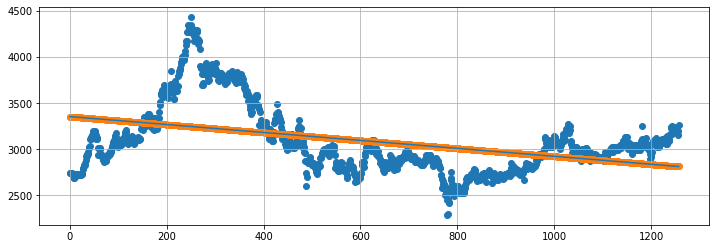

In [229]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func2(first_df.index, -4.30242244e-01,  3.35423078e+03))
plt.scatter(first_df.index, func2(first_df.index, -4.30242244e-01,  3.35423078e+03))
plt.grid()
plt.show()

In [268]:
popt, pcov = curve_fit(func3,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([ 4.44024883e-04, -9.88381521e-01,  3.47106793e+03])

In [270]:
np.sqrt(np.diag(pcov))

array([8.05921481e-05, 1.04631858e-01, 2.84739844e+01])

In [269]:
sum(np.sqrt(np.diag(pcov)))

28.578696898292502

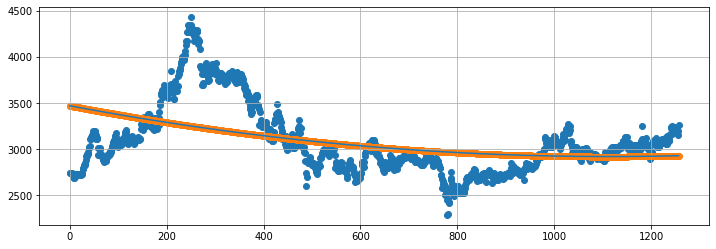

In [235]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func3(first_df.index, 4.44024883e-04, -9.88381521e-01,  3.47106793e+03))
plt.scatter(first_df.index, func3(first_df.index, 4.44024883e-04, -9.88381521e-01,  3.47106793e+03))
plt.grid()
plt.show()

In [264]:
popt, pcov = curve_fit(func4,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([ 5.91218017e-06, -1.07033909e-02,  4.61431083e+00,  2.88535298e+03])

In [265]:
sum(np.sqrt(np.diag(pcov)))

28.673924159658796

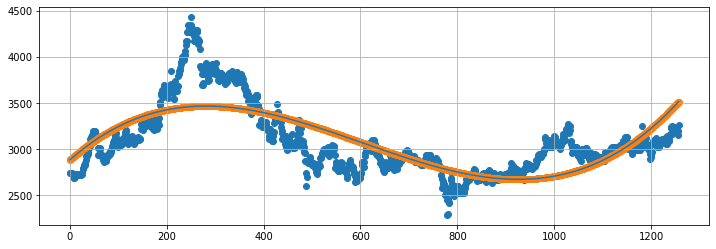

In [238]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func4(first_df.index, 5.91218017e-06, -1.07033909e-02,  4.61431083e+00,  2.88535298e+03))
plt.scatter(first_df.index, func4(first_df.index, 5.91218017e-06, -1.07033909e-02,  4.61431083e+00,  2.88535298e+03))
plt.grid()
plt.show()

In [262]:
popt, pcov = curve_fit(func5,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([-1.40373106e-08,  4.12019791e-05, -3.92125170e-02,  1.25704767e+01,
        2.38709754e+03])

In [263]:
sum(np.sqrt(np.diag(pcov)))

26.935612777985266

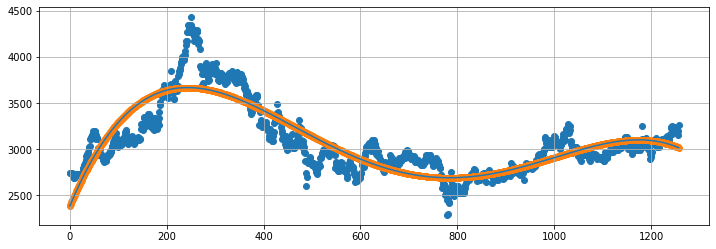

In [242]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func5(first_df.index, -1.40373106e-08,  4.12019791e-05, -3.92125170e-02,  1.25704767e+01,
        2.38709754e+03))
plt.scatter(first_df.index, func5(first_df.index, -1.40373106e-08,  4.12019791e-05, -3.92125170e-02,  1.25704767e+01,
        2.38709754e+03))
plt.grid()
plt.show()

In [259]:
popt, pcov = curve_fit(func6,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([ 3.41754270e-13, -1.51112736e-08,  4.24017158e-05, -3.97777063e-02,
        1.26718073e+01,  2.38287542e+03])

In [260]:
sum(np.sqrt(np.diag(pcov)))

32.42759685205813

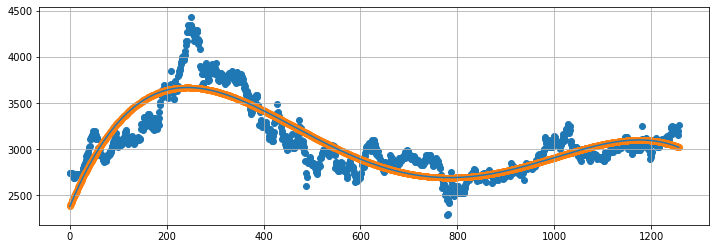

In [248]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func6(first_df.index, 3.41754270e-13, -1.51112736e-08,  4.24017158e-05, -3.97777063e-02,
        1.26718073e+01,  2.38287542e+03))
plt.scatter(first_df.index, func6(first_df.index, 3.41754270e-13, -1.51112736e-08,  4.24017158e-05, -3.97777063e-02,
        1.26718073e+01,  2.38287542e+03))
plt.grid()
plt.show()

In [257]:
popt, pcov = curve_fit(func7,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([ 6.56310572e-14, -2.47152906e-10,  3.38356211e-07, -1.94459491e-04,
        3.45821157e-02,  3.34703448e+00,  2.65973393e+03])

In [258]:
sum(np.sqrt(np.diag(pcov)))

34.60228108414014

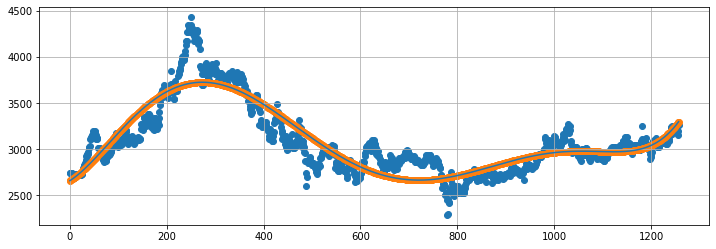

In [251]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func7(first_df.index, 6.56310572e-14, -2.47152906e-10,  3.38356211e-07, -1.94459491e-04,
        3.45821157e-02,  3.34703448e+00,  2.65973393e+03))
plt.scatter(first_df.index, func7(first_df.index, 6.56310572e-14, -2.47152906e-10,  3.38356211e-07, -1.94459491e-04,
        3.45821157e-02,  3.34703448e+00,  2.65973393e+03))
plt.grid()
plt.show()

In [252]:
popt, pcov = curve_fit(func8,first_df.index, first_df['AdjustedClose']) # poptは最適推定値、pcovは共分散
popt

array([-4.19250607e-18,  6.66283086e-14, -2.51242764e-10,  3.44757680e-07,
       -1.99176781e-04,  3.61850535e-02,  3.14723964e+00,  2.66510778e+03])

In [253]:
np.sqrt(np.diag(pcov))

array([1.12602514e-18, 4.09132724e-15, 1.54881204e-11, 2.24266967e-08,
       1.54988650e-05, 5.18325618e-03, 7.45905009e-01, 3.37075039e+01])

In [255]:
sum(np.sqrt(np.diag(pcov)))

34.45860773688007

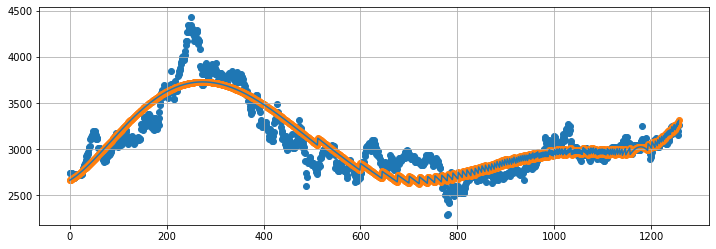

In [254]:
plt.figure(figsize=(12,4))
plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, func8(first_df.index, -4.19250607e-18,  6.66283086e-14, -2.51242764e-10,  3.44757680e-07,
       -1.99176781e-04,  3.61850535e-02,  3.14723964e+00,  2.66510778e+03))
plt.scatter(first_df.index, func8(first_df.index, -4.19250607e-18,  6.66283086e-14, -2.51242764e-10,  3.44757680e-07,
       -1.99176781e-04,  3.61850535e-02,  3.14723964e+00,  2.66510778e+03))
plt.grid()
plt.show()

In [272]:
pivot = df.pivot(index='Date', columns='SecuritiesCode', values='AdjustedClose')

In [298]:
pivot

SecuritiesCode,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,1414,1417,1419,1429,1431,1435,1515,1518,1605,1662,1663,1712,1716,1719,1720,1721,1723,1726,1762,1766,1775,1780,1787,1793,1799,1801,1802,1803,1805,1808,1810,1811,1812,1813,1814,1815,1820,1821,1822,1833,1835,1852,1860,1861,1870,1871,1873,1878,1879,1882,1884,1885,1887,1888,1890,1893,1898,1899,1911,1914,1921,1925,1926,1928,1929,1930,1934,1938,1939,1941,1942,1944,1945,1946,1949,1950,1951,1952,1954,1959,1961,1963,1965,1967,1968,1969,1973,1975,1976,1979,1980,1981,1982,2001,2002,2003,2004,2009,2053,2060,2108,2109,2114,2117,2120,2121,2124,2127,2130,2146,2148,2150,2153,2154,2157,2158,2160,2168,2170,2175,2181,2183,2185,2193,2198,2201,2204,2206,2207,2208,2209,2211,2212,2217,2220,2221,2222,2226,2229,2264,2266,2267,2268,2269,2270,2281,2282,2288,2292,2294,2296,2301,2305,2307,2309,2315,2317,2325,2326,2327,2329,2331,2335,2337,2349,2353,2359,2371,2372,2374,2378,2379,2384,2389,2393,2395,2412,2413,2418,2427,2429,2432,2433,2440,2445,2453,2461,2462,2469,2471,2475,2477,2484,2489,2491,2492,2497,2498,2501,2502,2503,2531,2533,2540,2573,2579,2587,2588,2590,2593,2594,2602,2607,2612,2613,2651,2653,2659,2664,2669,2670,2676,2678,2681,2685,2686,2692,2694,2695,2698,2702,2705,2715,2726,2729,2730,2733,2734,2737,2742,...,8890,8892,8897,8905,8909,8914,8917,8919,8920,8923,8925,8928,8929,8934,8935,8999,9001,9003,9005,9006,9007,9008,9009,9010,9014,9020,9021,9022,9024,9025,9028,9031,9033,9037,9039,9041,9042,9044,9045,9046,9048,9052,9055,9057,9058,9064,9065,9066,9068,9069,9070,9072,9075,9076,9081,9083,9086,9090,9099,9101,9104,9107,9110,9115,9119,9142,9143,9201,9202,9232,9233,9260,9267,9270,9273,9274,9278,9279,9301,9302,9303,9304,9305,9308,9310,9319,9324,9364,9368,9369,9375,9381,9384,9386,9401,9404,9405,9409,9412,9413,9414,9416,9418,9422,9424,9432,9433,9434,9435,9436,9438,9441,9449,9450,9467,9468,9470,9474,9501,9502,9503,9504,9505,9506,9507,9508,9509,9511,9513,9517,9519,9531,9532,9533,9534,9535,9536,9537,9539,9543,9551,9600,9601,9602,9603,9605,9612,9613,9616,9619,9621,9622,9627,9628,9629,9631,9632,9639,9640,9641,9658,9661,9663,9672,9678,9682,9684,9687,9692,9697,9699,9706,9708,9715,9716,9717,9719,9722,9726,9728,9729,9733,9735,9739,9740,9742,9743,9744,9746,9749,9755,9757,9759,9766,9769,9783,9787,9788,9790,9793,9795,9810,9823,9824,9828,9830,9831,9832,9837,9842,9843,9850,9856,9861,9869,9873,9880,9882,9887,9889,9896,9900,9902,9903,9906,9919,9928,9932,9934,9936,9945,9946,9948,9955,9956,9960,9962,9974,9977,9979,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,2742.0,571.0,3210.0,NaN,1550.0,3330.0,2143.0,1960.0,512.4,NaN,2525.0,1053.0,535.0,418.0,NaN,833.0,5720.0,1330.0,1190.0,2672.0,1871.0,1235.8,511.5,795.0,950.0,2187.0,2088.0,261.0,2488.0,8580.0,1660.0,563.0,2448.0,3980.0,1162.0,4175.0,1137.0,1101.0,1870.0,1218.0,1068.0,5080.0,1660.0,2150.0,1009.0,3480.0,2965.0,625.0,2835.0,3350.0,3070.0,3840.0,643.0,3050.0,1102.0,399.0,514.0,17810.0,1003.0,3610.0,4710.0,2004.0,NaN,1580.0,418.0,576.0,507.0,5750.0,1584.0,366.0,365.0,3315.0,1223.0,1987.0,476.0,733.3,820.0,1159.0,1137.5,2615.0,1073.0,1493.0,1019.0,2880.0,1297.0,1880.0,1720.0,1298.0,2622.0,3090.0,1003.0,2172.0,775.0,579.0,2352.0,1532.0,725.3,2970.0,582.0,2958.0,1960.0,637.0,1705.0,1668.0,1777.0,1930.0,3050.0,779.0,1034.0,810.0,2369.0,2524.0,507.0,1648.0,794.0,4350.0,1345.0,815.0,510.0,982.0,602.0,96.3,477.5,859.0,520.3,897.0,810.0,824.0,457.0,1284.0,1826.0,1341.0,540.0,1045.0,687.0,4855.0,5060.0,5530.0,1391.0,2391.0,1403.0,2210.0,2282.0,2560.0,5360.0,4140.0

In [318]:
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [316]:
from scipy.stats import boxcox

In [359]:
def mae(x, y):
    return abs(x - y)

In [352]:
pivot.fillna(0, inplace=True)

In [321]:
mm_scaler = MinMaxScaler()
normalized_pivot = mm_scaler.fit_transform(pivot)

In [339]:
normalized_pivot[:, 0]

array([0.21158337, 0.20971509, 0.21064923, ..., 0.42316674, 0.40214853,
       0.45586175])

In [340]:
normalized_pivot[:, 1]

array([0.37946429, 0.37276786, 0.38839286, ..., 0.29464286, 0.29241071,
       0.31919643])

In [347]:
normalized_pivot.shape[1]

2000

In [350]:
normalized_pivot[:, 1999]

array([0.34201077, 0.36355476, 0.36894075, ..., 0.28904847, 0.3016158 ,
       0.30251346])

In [369]:
normalized_pivot_mae = [[sum(np.vectorize(mae)(normalized_pivot[:, j], normalized_pivot[:, i])) for i in range(normalized_pivot.shape[1])] for j in range(30)]


In [370]:
normalized_pivot_mae

[[0.0,
  238.17430940148157,
  212.68944701839655,
  508.2507122023236,
  370.6026549438356,
  283.7210506060228,
  272.34040009816346,
  138.61289474902284,
  395.1743053280736,
  218.83703017951876,
  423.37639742081853,
  280.6301264502224,
  316.35694747458246,
  403.5552804785556,
  475.61322383144915,
  244.2946798244428,
  178.2731989856799,
  238.4540260726611,
  206.48603161860865,
  193.91478886640004,
  233.40521938118695,
  229.7992492187386,
  316.2229444623152,
  209.7272619809597,
  205.89162770009267,
  346.31092825828546,
  378.26260550613006,
  298.6985334301434,
  237.53039163833924,
  182.68085791070422,
  249.3676120260021,
  406.2408921064919,
  332.6564514636588,
  220.66281999341103,
  355.7535865681948,
  167.95938082440372,
  174.3010691211936,
  197.28221968843584,
  211.11234408141232,
  170.89947690241786,
  175.4358169172209,
  147.6226633402362,
  101.22179546463137,
  276.89663903513724,
  161.49813903119855,
  277.53882776283353,
  219.8297135848696,
  

In [374]:
[len([i for i, c in enumerate(mae) if c < 150]) for mae in normalized_pivot_mae]

[158,
 3,
 48,
 48,
 7,
 11,
 8,
 30,
 100,
 34,
 23,
 61,
 113,
 2,
 65,
 8,
 27,
 21,
 94,
 6,
 11,
 7,
 29,
 11,
 92,
 6,
 15,
 14,
 79,
 11]

In [287]:
np.subtract(pivot[1301].values, pivot.values)

ValueError: operands could not be broadcast together with shapes (1258,) (1258,2000) 

In [166]:
trade = pd.read_csv('../Input/train_files/trades.csv')
option = pd.read_csv('../Input/train_files/options.csv')

/var/folders/ym/2nhqmm5d6zn8mfrndqmv6l_40000gn/T/ipykernel_26093/1506442453.py:2: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  option = pd.read_csv('../Input/train_files/options.csv')


In [169]:
trade.shape

(1712, 56)

In [170]:
trade.tail()

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,ProprietaryTotal,ProprietaryBalance,BrokerageSales,BrokeragePurchases,BrokerageTotal,BrokerageBalance,IndividualsSales,IndividualsPurchases,IndividualsTotal,IndividualsBalance,ForeignersSales,ForeignersPurchases,ForeignersTotal,ForeignersBalance,SecuritiesCosSales,SecuritiesCosPurchases,SecuritiesCosTotal,SecuritiesCosBalance,InvestmentTrustsSales,InvestmentTrustsPurchases,InvestmentTrustsTotal,InvestmentTrustsBalance,BusinessCosSales,BusinessCosPurchases,BusinessCosTotal,BusinessCosBalance,OtherInstitutionsSales,OtherInstitutionsPurchases,OtherInstitutionsTotal,OtherInstitutionsBalance,InsuranceCosSales,InsuranceCosPurchases,InsuranceCosTotal,InsuranceCosBalance,CityBKsRegionalBKsEtcSales,CityBKsRegionalBKsEtcPurchase,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
1707,2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708,2021-12-02,2021-11-22,2021-11-26,Growth Market (Mothers/JASDAQ),1.143466e+09,1.143923e+09,2.287389e+09,456677.0,3.663919e+07,3.496068e+07,7.159987e+07,-1678508.0,1.106827e+09,1.108962e+09,2.215789e+09,2135185.0,6.317277e+08,6.508934e+08,1.282621e+09,19165664.0,4.222267e+08,3.995653e+08,8.217920e+08,-22661428.0,19532301.0,20335113.0,39867414.0,802812.0,5712311.0,6802056.0,12514367.0,1089745.0,13241913.0,16476738.0,29718651.0,3234825.0,6947933.0,7211377.0,14159310.0,263444.0,170792.0,433284.0,604076.0,262492.0,335919.0,60311.0,396230.0,-275608.0,6696755.0,6886122.0,13582877.0,189367.0,234653.0,298525.0,533178.0,63872.0
1709,2021-12-02,2021-11-22,2021-11-26,Prime Market (First Section),1.138343e+10,1.137621e+10,2.275964e+10,-7214179.0,1.499660e+09,1.230944e+09,2.730604e+09,-268716111.0,9.883766e+09,1.014527e+10,2.002903e+10,261501932.0,2.042100e+09,2.433004e+09,4.475104e+09,390904459.0,7.137596e+09,6.912257e+09,1.404985e+10,-225339255.0,74894037.0,88791160.0,163685197.0,13897123.0,183078463.0,159026769.0,342105232.0,-24051694.0,123642633.0,211502023.0,335144656.0,87859390.0,18341982.0,43479826.0,61821808.0,25137844.0,10839136.0,9695681.0,20534817.0,-1143455.0,26734116.0,9223824.0,35957940.0,-17510292.0,254580089.0,261919512.0,516499601.0,7339423.0,11959898.0,16368287.0,28328185.0,4408389.0
1710,2021-12-02,2021-11-22,2021-11-26,Standard Market (Second Section),1.069969e+08,1.075036e+08,2.145004e+08,506702.0,2.811025e+06,3.273163e+06,6.084188e+06,462138.0,1.041858e+08,1.042304e+08,2.084162e+08,44564.0,6.587397e+07,6.573161e+07,1.316056e+08,-142356.0,2.898821e+07,2.868161e+07,5.766982e+07,-306605.0,2983832.0,3003763.0,5987595.0,19931.0,543907.0,367291.0,911198.0,-176616.0,4948282.0,5634326.0,10582608.0,686044.0,258986.0,560994.0,819980.0,302008.0,47298.0,0.0,47298.0,-47298.0,42127.0,0.0,42127.0,-42127.0,438928.0,243817.0,682745.0,-195111.0,60291.0,6985.0,67276.0,-53306.0
1711,2021-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
option.shape

(3567694, 31)

In [168]:
option.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,DaySessionOpen,DaySessionHigh,DaySessionLow,DaySessionClose,TradingVolume,OpenInterest,TradingValue,ContractMonth,StrikePrice,DaySessionVolume,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,0.0000,650.0,650.0,480.0,480.0,6,19,3455000,201701,20000.0,6,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20125.0,0,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,5,0,201701,20250.0,0,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20375.0,0,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,201701,20500.0,0,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [175]:
tmp = option[option['Date'] == '2017-01-04']

In [176]:
tmp

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,DaySessionOpen,DaySessionHigh,DaySessionLow,DaySessionClose,TradingVolume,OpenInterest,TradingValue,ContractMonth,StrikePrice,DaySessionVolume,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,0.0000,650.0,650.0,480.0,480.0,6,19,3455000,201701,20000.0,6,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0000,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20125.0,0,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0000,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,5,0,201701,20250.0,0,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0000,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20375.0,0,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0000,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,201701,20500.0,0,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,20170104_196062518,2017-01-04,196062518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,202106,22500.0,0,2,20210610,20210611,1800.0,1798.0282,17.4736,20.8153,0.1282,1.6974,0.0
2170,20170104_196062718,2017-01-04,196062718,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,202106,22750.0,0,2,20210610,20210611,1750.0,1741.5025,17.4736,20.8368,0.1282,1.6974,0.0
2171,20170104_196063018,2017-01-04,196063018,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,202106,23000.0,0,2,20210610,20210611,1690.0,1687.0561,17.4736,20.8597,0.1282,1.6974,0.0
2172,20170104_196063218,2017-01-04,196063218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,202106,23250.0,0,2,20210610,20210611,1640.0,1634.9724,17.4736,20.8864,0.1282,1.6974,0.0


In [171]:
option.OptionsCode.nunique()

14732

In [177]:
option.OptionsCode.unique()

array([132010018, 132010118, 132010218, ..., 197152018, 197153018,
       197154018])

In [188]:
option['transaction_type'] = option['OptionsCode'].astype(str).str[1:2].astype(int)

In [193]:
def put_call(x):
    '''
    return value about put/call
    put: 0
    call: 1
    Futures transaction: 2
    '''
    if x == 1 or x == 5:
        return 0
    elif x == 2 or x == 7:
        return 1
    elif x == 3 or x == 8:
        return 0
    elif x == 4 or x == 9:
        return 1
    elif x == 6:
        return 2

In [194]:
def spot_futures(x):
    '''
    return value about spot/futures
    spot: 0
    futures: 1
    Futures transaction: 2
    '''
    if x == 1 or x == 5:
        return 1
    elif x == 2 or x == 7:
        return 1
    elif x == 3 or x == 8:
        return 0
    elif x == 4 or x == 9:
        return 0
    elif x == 6:
        return 2

In [195]:
option['put/call'] = option['transaction_type'].apply(put_call)
option['spot/futures'] = option['transaction_type'].apply(spot_futures)

In [196]:
option['year_type'] = option['OptionsCode'].astype(str).str[2].astype(int)

In [197]:
option['month_type'] = option['OptionsCode'].astype(str).str[3:5].astype(int)

In [198]:
option['exercise_price_type'] = option['OptionsCode'].astype(str).str[5:7].astype(int)